In [1]:
from src.all_functions import *
from src.communities.communities import *

In [2]:
import _pickle as pickle

In [3]:
from collections import Counter, defaultdict
import itertools

In [4]:
import networkx as nx
import pandas as pd

In [5]:
pickle_in = open("./data/pandas/flavorDB_pandas.pickle","rb")

#Getting the dictionary from the pickle
flavorDB = pickle.load(pickle_in)

In [6]:
flavorDB.head()

,_id,category,flavor_of_molecules,ingredient,molecule_IDs,molecules,set_molecules,set_molecules_ID,molecule_quantity
127,5ca27ddc13218a1eabac6455,Berry,"[[sweet, new mown hay, green, tonka, bitte...",sea buckthorns,"[323, 107971, 7284, 10448, 7150, 638011, 8468,...","[coumarin, Daidzin, 2-Methylbutyraldehyde, 3-m...","{3-Methylbutyl 2-methylbutanoate, Neral, L-Rha...","{7150, 11552, 61386, 444539, 7775, 8723, 11509...",113
133,5ca27de313218a1eabac645b,Seafood,"[[cherry, caramel, nut, phenolic], [apple, ...",clam,"[14511, 8785, 8193, 8163, 8063, 9862, 7909, 79...","[3-Methyl-2-Cyclohexen-1-One, Benzyl Acetate, ...","{2-Methylpyrazine, 2-Nonanone, Octanal, 2,3-Di...","{1031, 11552, 996, 1549778, 14296, 19602, 1082...",61
134,5ca27de513218a1eabac645c,Seafood,"[[coconut, wax, fat, waxy, fatty, earthy,...",crab,"[8193, 8063, 5281, 7909, 7501, 7519, 8051, 188...","[1-Dodecanol, Pentanal, stearic acid, 4-Methyl...","{Octanal, methanethiol, phenol, 2-Acetylpyrrol...","{11552, 996, 14296, 19602, 454, 8129, 11509, 7...",38
135,5ca27de613218a1eabac645d,Seafood,"[[orange, waxy, fresh, fatty, floral, iri...",crayfish,"[8163, 5283321, 7501, 8051, 18635, 7002, 454, ...","[2-Undecanone, trans,trans-2,4-Heptadienal, St...","{2-Methylpyrazine, 2-Nonanone, Octanal, phenol...","{11552, 996, 61235, 454, 8129, 7501, 26331, 89...",32
136,5ca27de713218a1eabac645e,Seafood,"[[sweet, new mown hay, green, tonka, bitte...",kelp,"[323, 107971, 7284, 10448, 7150, 638011, 64373...","[coumarin, Daidzin, 2-Methylbutyraldehyde, 3-m...","{Neral, Isoeugenol, 2-Isopropyl-5-methylcycloh...","{7150, 11552, 444539, 8723, 8103, 11509, 53185...",104


In [7]:
print("number of ingredients: ", flavorDB["ingredient"].count())

number of ingredients:  516


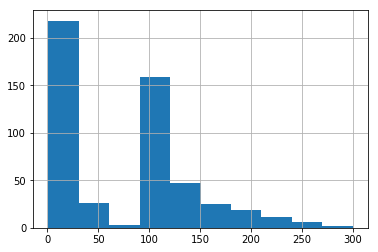

In [9]:
#Distribution of flavor molecules per ingredients
flavorDB["molecule_quantity"].hist()

In [10]:
#Distribution of flavor molecules per ingredients
flavorDB["molecule_quantity"].describe()

count    516.000000
mean      71.538760
std       67.783525
min        1.000000
25%        3.000000
50%       92.000000
75%      110.250000
max      300.000000
Name: molecule_quantity, dtype: float64

# Within Category Ratio


In [11]:
#Distribution of ingredients per category
flavorDB.groupby("category")["ingredient"].count()

category
Berry                42
Cabbage              16
Fish                120
Fruit                82
Fruit Citrus         10
Fruit Essence         1
Fungus               11
Herb                 51
Meat                 46
Nut                  21
Plant Derivative     20
Seafood              35
Spice                25
Vegetable            24
Vegetable Fruit       4
Vegetable Root        8
Name: ingredient, dtype: int64

In [12]:
"""
takes a while to process, so commented out
"""
# list_of_category_ratios = []
# for category in list_of_categories:
#     if len(ingredient_only_pd[ingredient_only_pd["category"] == category]["ingredient"]) > 1:
#         list_of_ingredients_per_category = ingredient_only_pd[ingredient_only_pd["category"] == category]["ingredient"].tolist()
#         ratio_total = 0
#         for combo in combinations(list_of_ingredients_per_category, 2):
#             ratio, x, y, z = common_pair_analysis(combo[0], combo[1])
#             ratio_total += ratio
#         category_ratio = ratio_total / len(list(combinations(list_of_ingredients_per_category, 2)))
#         list_of_category_ratios.append(category_ratio)
#         print("Ratio for {}: ".format(category), category_ratio)

'\ntakes a while to process, so commented out\n'

Ratio for Berry: 0.35719197257990054 Ratio for Fish: 0.41460354837905844 Ratio for Fruit: 0.3786900657335132 Ratio for Fruit Citrus: 0.3884684724638544 Ratio for Fungus: 0.41409691629955947 Ratio for Herb: 0.5326167800571301 Ratio for Meat: 0.13390955730473256 Ratio for Nut: 0.5507713353522316 Ratio for Plant Derivative: 0.09379168158647629 Ratio for Seafood: 0.16144490977143952 Ratio for Spice: 0.4443326703423937 Ratio for Vegetable: 0.5939392378952064 Ratio for Vegetable Root: 0.6347922930979436

(0.0044444444444444444, 8, 216, 1)

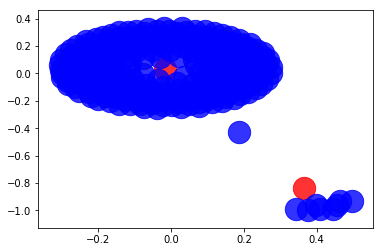

In [14]:
common_pair_analysis("celery", "peanut butter", flavorDB, True)

(0.31176470588235294, 39, 78, 53)

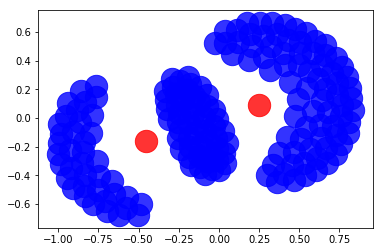

In [16]:
common_pair_analysis("chicken", "beef", flavorDB, True)

(0.05058365758754864, 244, 0, 13)

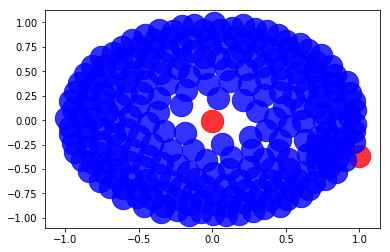

In [17]:
common_pair_analysis("chocolate", "strawberry", flavorDB, True)

# Making a Graph
graph that has ingredients as nodes and edges if the ratio is above a certain level

In [ ]:
my_graph = graph_based_on_shared_molecule_creator(pandas_df= flavorDB, min_intersection_ratio= 0)